# Get BFCs from the list of annotated commits
They will be stored in `BFCs['estimated']`

In [297]:
import os
import pandas as pd

annotations_dir = "comparison-3"
annotations_dir = "commit-annotator"
reviews_dir = "comparison-3"

def get_BFCs(results_df):
    df = results_df[['hash', 'bfc']]
    return df

def read_csv_from_dir(dirname, filename):
    results = pd.read_csv(os.path.join('..', dirname, filename))
    return results
    
results_A = read_csv_from_dir(annotations_dir, 'annotations_Michel.csv')
results_B = read_csv_from_dir(annotations_dir, 'annotations_Abhishek.csv')
results_C = read_csv_from_dir(annotations_dir, 'annotations_David.csv')

BFCs_A = get_BFCs(results_A)
BFCs_B = get_BFCs(results_B)
BFCs_C = get_BFCs(results_C)

BFCs = pd.merge(BFCs_A, BFCs_B, on='hash', how='inner', suffixes=('A', 'B'))

BFCs = pd.merge(BFCs, BFCs_C, on='hash', how='inner', suffixes=('', 'C'))
BFCs = BFCs[['hash', 'bfcA', 'bfcB', 'bfc']]
BFCs = BFCs.rename(columns={'bfc': 'bfcC'})

In [298]:
BFCs_R = read_csv_from_dir(reviews_dir, 'review_jesus.csv')
BFCs = pd.merge(BFCs, BFCs_R, on='hash', how='left')
BFCs['bfcR'] = BFCs['bfc']
BFCs = BFCs[['hash', 'bfcA', 'bfcB', 'bfcC', 'bfcR']]

In [299]:
import math

def estimation(A, B, C, R):
    if math.isnan(R):
        return round((A + B + C) / 3)
    else:
        return R
BFCs['estimation'] = BFCs.apply(lambda row: estimation(row['bfcA'], row['bfcB'], row['bfcC'], row['bfcR']), axis=1) 

In [300]:
BFCs['estimation'].value_counts()

estimation
0.0    697
4.0    184
3.0     11
2.0     10
1.0      9
Name: count, dtype: int64

# Get commits in LTS branches

In [301]:
LTS_commits = pd.read_csv('upstream_commits.csv', converters={'branch': str, 'minor': str})
LTS_commits['hash'] = LTS_commits['commit'].str[:10]
LTS_commits[['branch_major', 'branch_minor']] = LTS_commits['branch'].str.split('.', expand=True)
LTS_commits['branch'] = LTS_commits['branch_major'] + '.' + LTS_commits['branch_minor'].str.zfill(2)
LTS_commits['minor'] = LTS_commits['minor'].str.zfill(3)
LTS_commits.sort_values(['branch_major','branch_minor'], inplace=True)
print(f"Upstream commits found: {len(LTS_commits)}")
print(f"Unique upstream commits found: {len(LTS_commits['hash'].unique())}")
LTS_commits

Upstream commits found: 277460
Unique upstream commits found: 90895


,branch,minor,commit,hash,branch_major,branch_minor
204400,4.01,001,15bf722e6f6c0b884521a0363204532e849deb7f,15bf722e6f,4,1
204401,4.01,001,90f91b129810c3f169e443252be30ed7c0130326,90f91b1298,4,1
204402,4.01,001,0d0cef6183aec0fb6d0c9f00a09ff51ee086bbe2,0d0cef6183,4,1
204403,4.01,001,692c062e7c282164fd7cda68077f79dafd176eaf,692c062e7c,4,1
204404,4.01,001,7e730c7f3d1f39c25cf5f7cf70c0ff4c28d7bec7,7e730c7f3d,4,1
...,...,...,...,...,...,...
9572,6.06,009,0913445082496c2b29668ee26521401b273838b8,0913445082,6,6
9573,6.06,009,686c4a5a42635e0d2889e3eb461c554fd0b616b4,686c4a5a42,6,6
9574,6.06,009,6376a824595607e99d032a39ba3394988b4fce96,6376a82459,6,6
9575,6.06,009,4472edf63d6630e6cf65e205b4fc8c3c94d0afe5,4472edf63d,6,6


# Some analysis of upstream commits by branch

In [303]:
#LTS_counts = LTS_commits.groupby(['branch', 'minor']).size()
LTS_counts = LTS_commits.groupby(['branch', 'minor']).size().reset_index(name='count')
#display(LTS_counts.head(100))

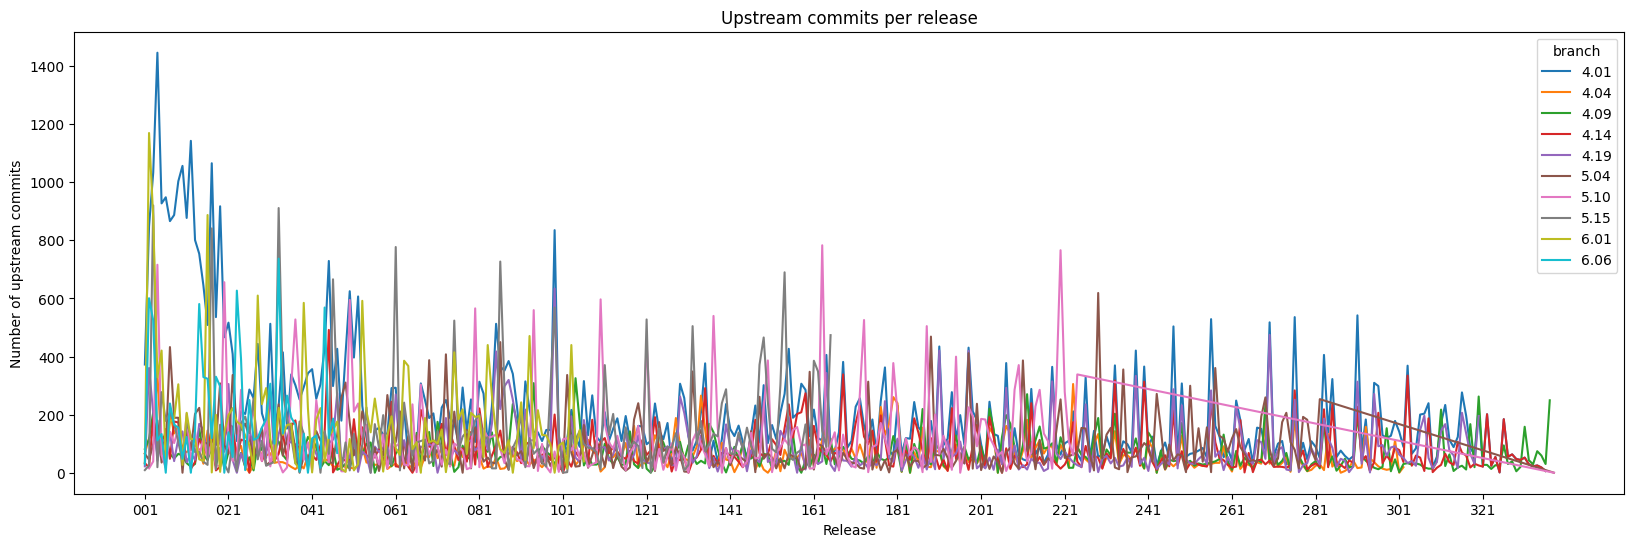

In [304]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 6))
lp = sns.lineplot(data=LTS_counts, x='minor', y='count', hue='branch')
plt.xlabel('Release')
plt.ylabel('Number of upstream commits')
plt.title('Upstream commits per release')
x_ticks = LTS_counts['minor'].unique()[::20]
plt.xticks(range(0,len(x_ticks)*20,20), x_ticks)
plt.show()

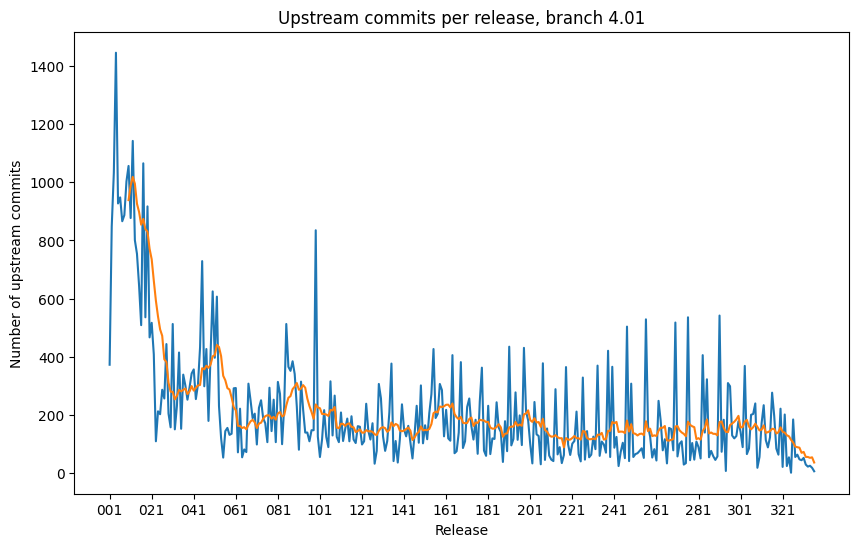

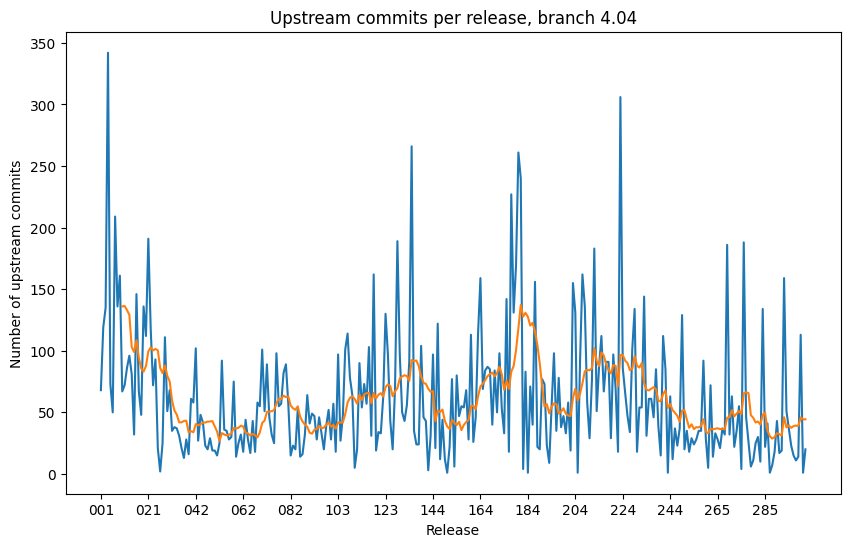

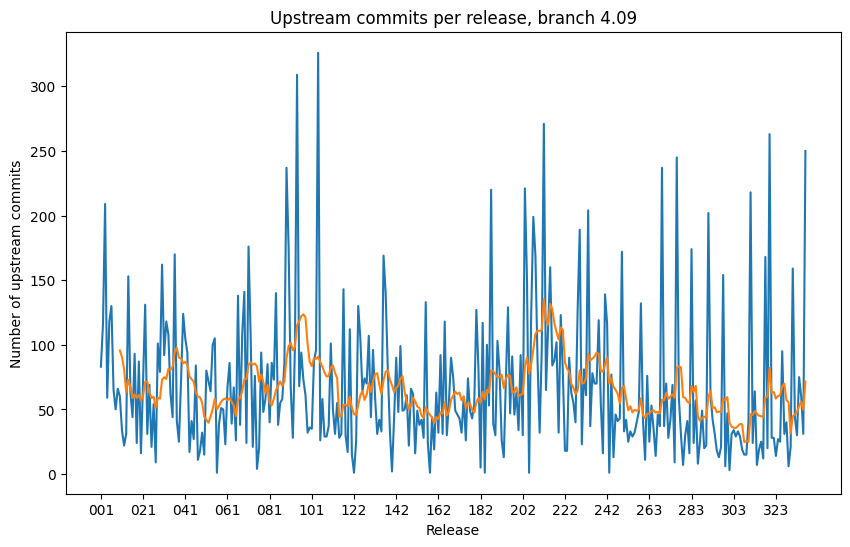

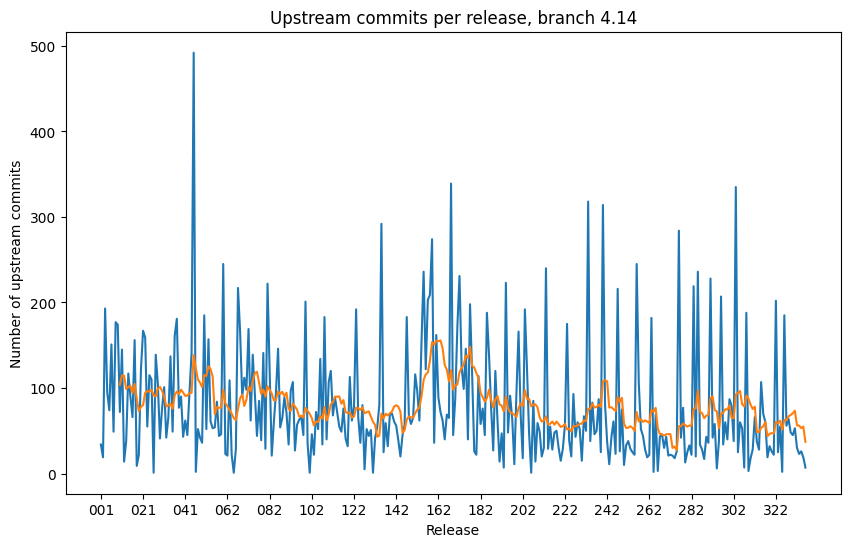

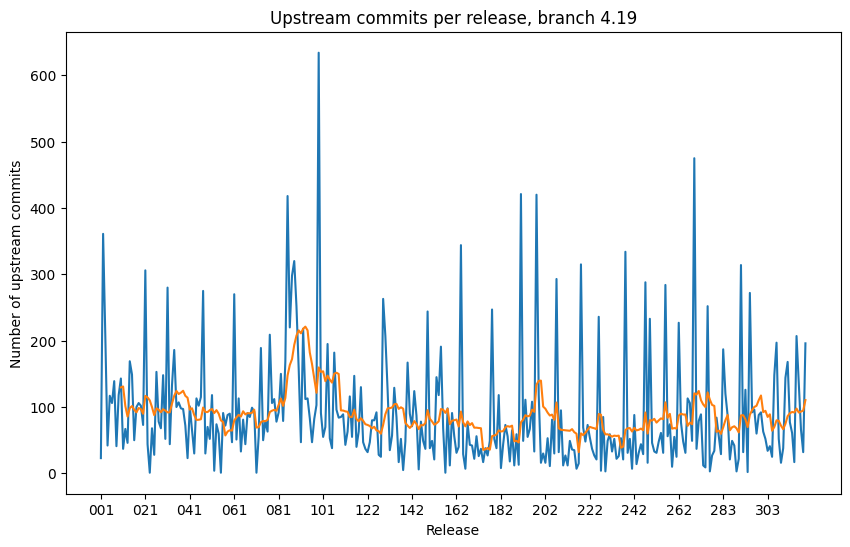

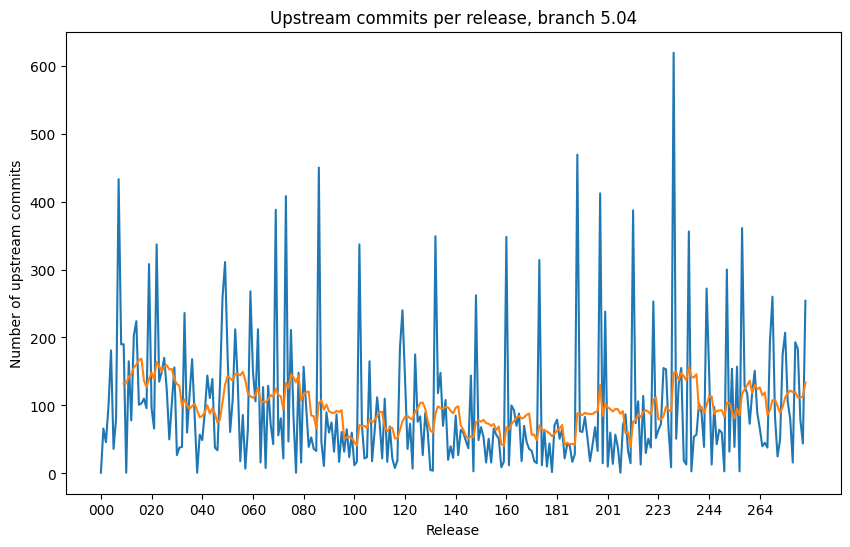

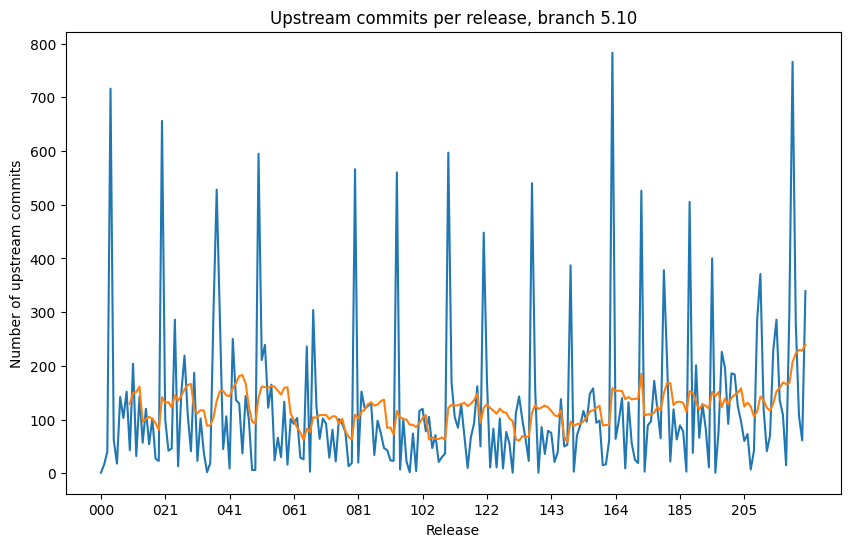

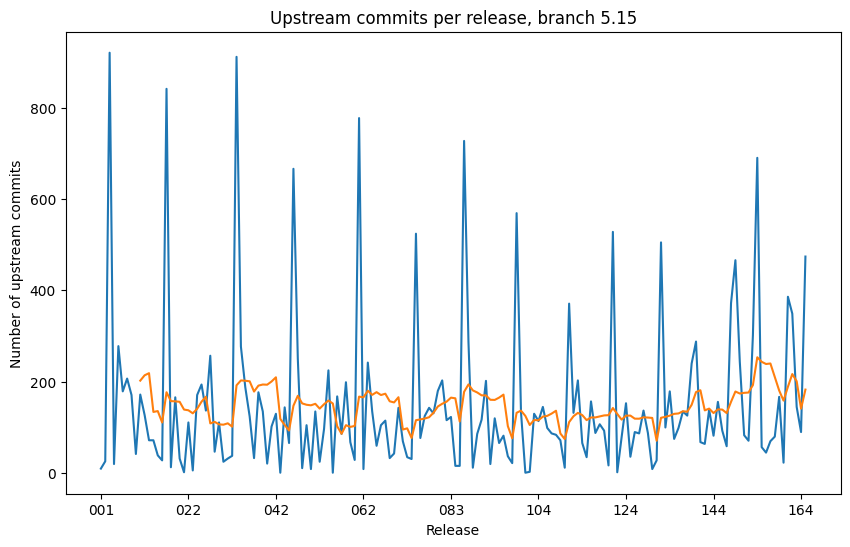

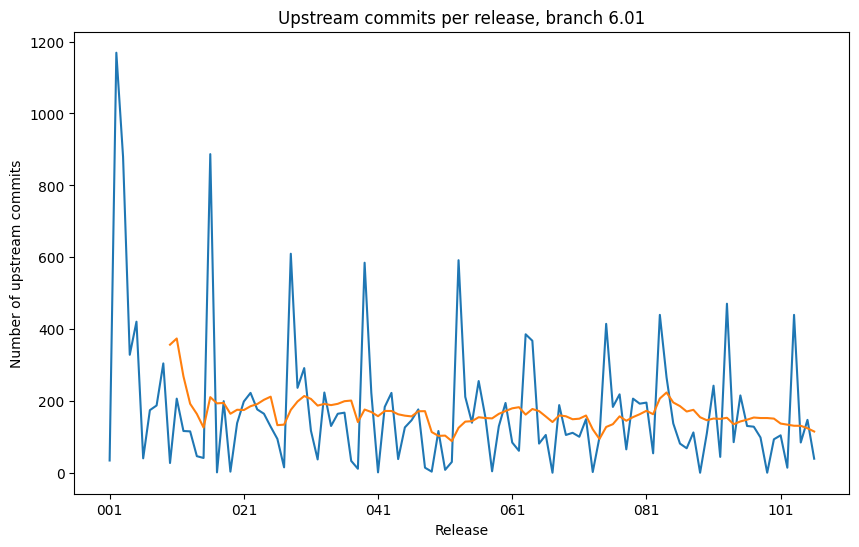

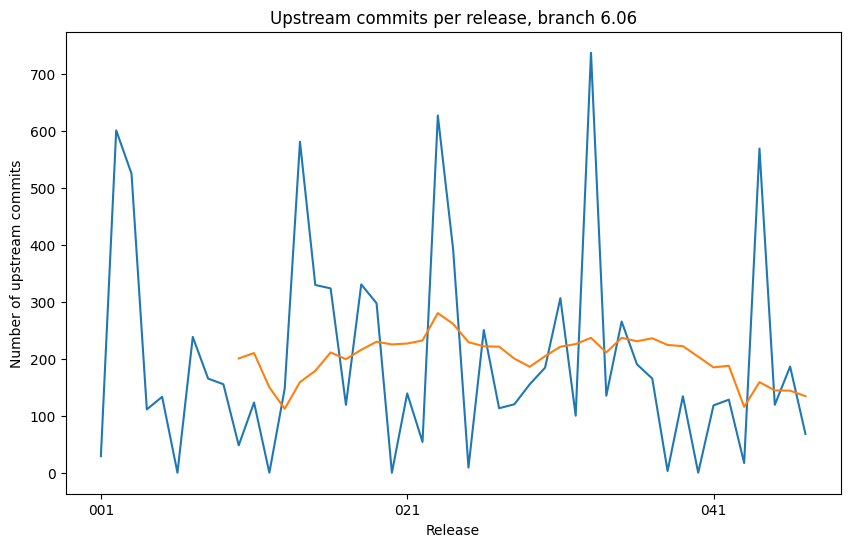

In [313]:
pd.options.mode.copy_on_write = True
for branch in LTS_counts['branch'].unique():
    branch_counts = LTS_counts[LTS_counts['branch'] == branch]
    branch_counts['mean'] = branch_counts['count'].rolling(10).mean()
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=branch_counts, x='minor', y='count')
    sns.lineplot(data=branch_counts, x='minor', y='mean')
    plt.xlabel('Release')
    plt.ylabel('Number of upstream commits')
    plt.title(f'Upstream commits per release, branch {branch}')
    x_ticks = branch_counts['minor'].unique()[::20]
    plt.xticks(range(0,len(x_ticks)*20,20), x_ticks)
    #plt.show()
    plt.savefig(os.path.join("figs", f"upstream_commits_release_{branch}.eps"))

# Merge and analyze annotated commits found in LTS branches

In [306]:
LTS_annotated = pd.merge(LTS_commits, BFCs, on='hash', how='left')
#LTS_annotated['estimation'].value_counts()

In [307]:
commit_url = "https://git.kernel.org/pub/scm/linux/kernel/git/torvalds/linux.git/commit/?id={hash}"

LTS_annotated = LTS_annotated[LTS_annotated['estimation'].notna()]
LTS_annotated['link'] = LTS_annotated['commit'].apply(lambda hash: "<a href='" + commit_url.format(hash=hash) + "'>Link</a>")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
#LTS_annotated

In [308]:
bfc_counts = LTS_annotated.groupby('branch')['estimation'].value_counts()
bfc_fractions = LTS_annotated.groupby('branch')['estimation'].value_counts(normalize=True)
display(bfc_counts, bfc_fractions)

branch  estimation
4.01    4.0           57
        0.0           24
        1.0            4
        2.0            2
        3.0            2
4.09    4.0           20
        0.0            5
        1.0            1
        2.0            1
        3.0            1
4.14    4.0           26
        0.0            8
        1.0            2
        2.0            1
        3.0            1
4.19    4.0           31
        0.0           16
        1.0            2
        2.0            1
        3.0            1
5.04    4.0           40
        0.0           20
        1.0            2
        2.0            2
        3.0            1
5.10    4.0           64
        0.0           27
        1.0            4
        2.0            2
        3.0            1
5.15    4.0           92
        0.0           42
        1.0            4
        2.0            2
        3.0            1
6.01    0.0           14
        4.0            9
        1.0            1
        2.0            1
      

branch  estimation
4.01    4.0           0.640449
        0.0           0.269663
        1.0           0.044944
        2.0           0.022472
        3.0           0.022472
4.09    4.0           0.714286
        0.0           0.178571
        1.0           0.035714
        2.0           0.035714
        3.0           0.035714
4.14    4.0           0.684211
        0.0           0.210526
        1.0           0.052632
        2.0           0.026316
        3.0           0.026316
4.19    4.0           0.607843
        0.0           0.313725
        1.0           0.039216
        2.0           0.019608
        3.0           0.019608
5.04    4.0           0.615385
        0.0           0.307692
        1.0           0.030769
        2.0           0.030769
        3.0           0.015385
5.10    4.0           0.653061
        0.0           0.275510
        1.0           0.040816
        2.0           0.020408
        3.0           0.010204
5.15    4.0           0.652482
        0.0         

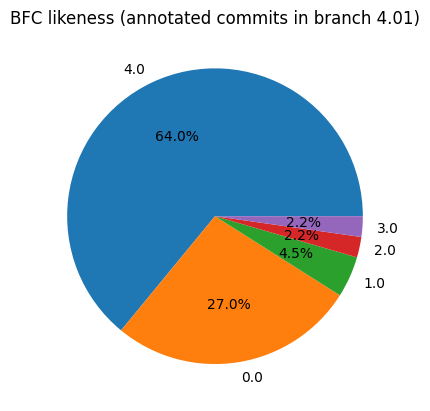

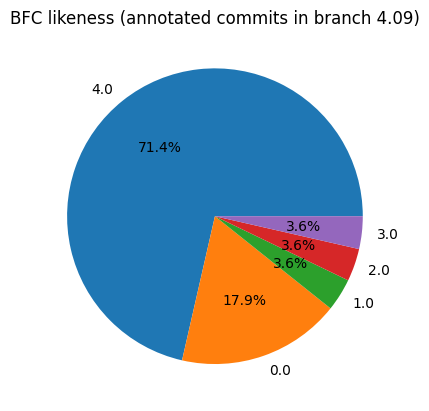

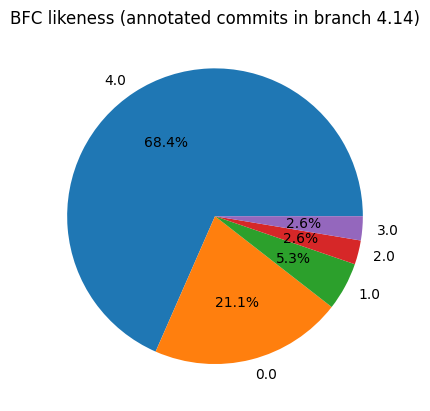

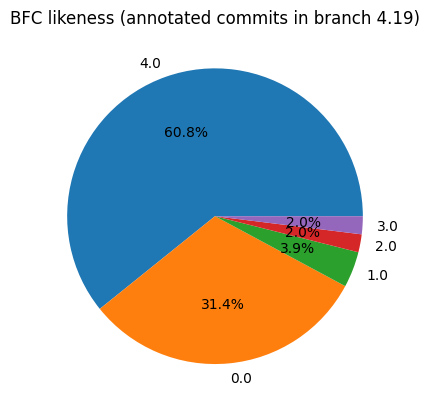

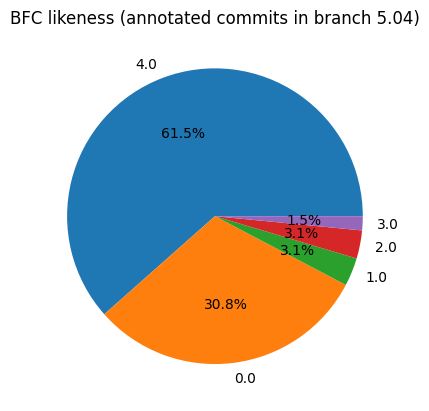

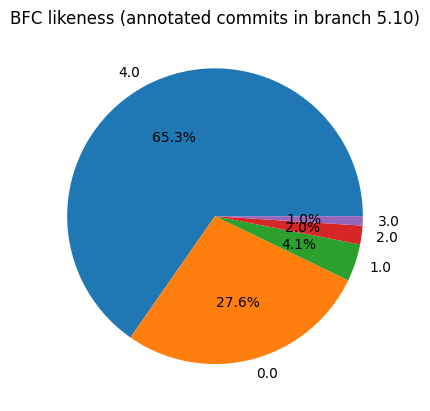

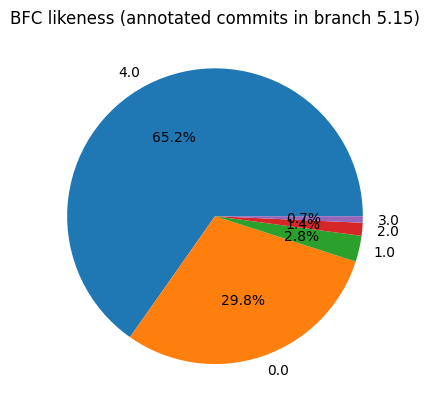

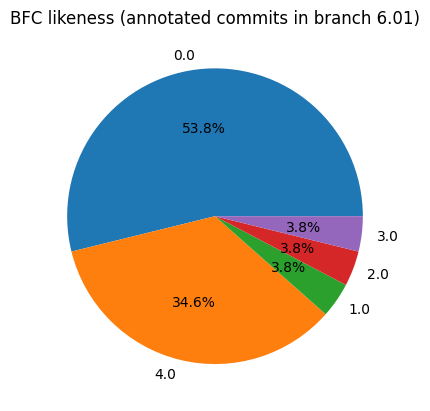

In [314]:
for branch in bfc_counts.index.levels[0]:
    plt.figure()
    plt.pie(bfc_counts.loc[branch], labels=bfc_counts.loc[branch].index, autopct='%1.1f%%')
    plt.title(f'BFC likeness (annotated commits in branch {branch})')
    #plt.show()
    plt.savefig(os.path.join("figs", f"upstream_commits_annotated_bfc_{branch}.eps"))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 2000x600 with 0 Axes>

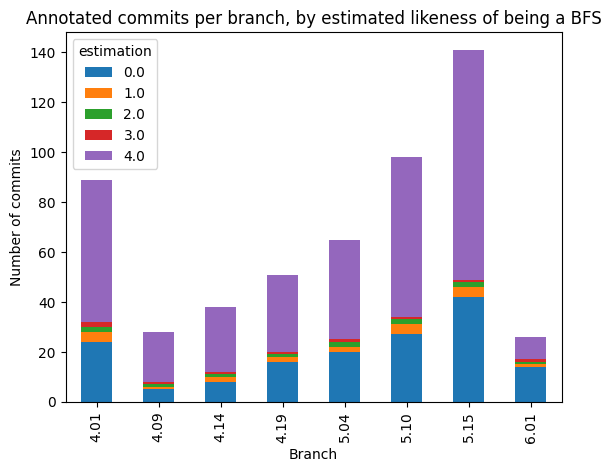

<Figure size 2000x600 with 0 Axes>

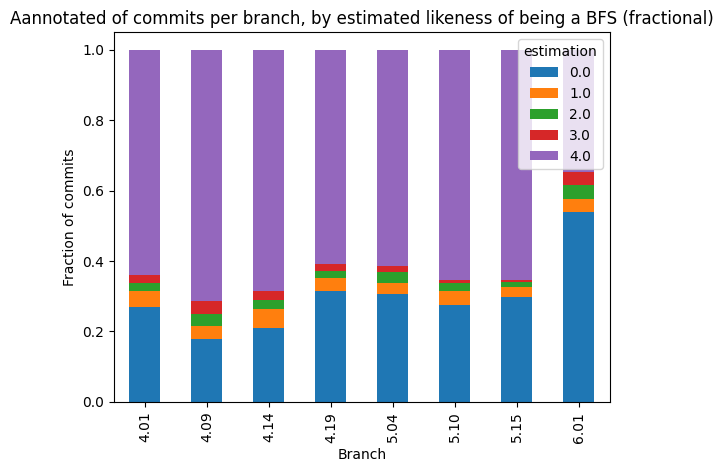

In [315]:
plt.figure(figsize=(20, 6))
bfc_counts.unstack().plot(kind="bar", stacked=True)
plt.title("Annotated commits per branch, by estimated likeness of being a BFS")
plt.xlabel("Branch")
plt.ylabel("Number of commits")
#plt.show()
plt.savefig(os.path.join("figs", f"annotated_commits_branch_bfs.eps"))

plt.figure(figsize=(20, 6))
bfc_fractions.unstack().plot(kind="bar", stacked=True)
plt.title("Aannotated of commits per branch, by estimated likeness of being a BFS (fractional)")
plt.xlabel("Branch")
plt.ylabel("Fraction of commits")
#plt.show()
plt.savefig(os.path.join("figs", f"annotated_commits_branch_bfs_fraction.eps"))

In [216]:
from IPython.display import HTML

HTML(LTS_annotated.to_html(escape=False))
#HTML(LTS_annotated.loc[LTS_annotated['estimation'] < 4, :].to_html(escape=False))

,branch,minor,commit,hash,branch_major,branch_minor,bfcA,bfcB,bfcC,bfcR,estimation,link
25128,4.01,266,bd2db32e7c3e35bd4d9b8bbff689434a50893546,bd2db32e7c,4,1,4.0,4.0,3.0,4.0,4.0,Link
25409,4.01,270,6c1f41afc1dbe59d9d3c8bb0d80b749c119aa334,6c1f41afc1,4,1,4.0,2.0,4.0,4.0,4.0,Link
25476,4.01,273,16b1941eac2bd499f065a6739a40ce0011a3d740,16b1941eac,4,1,4.0,4.0,2.0,4.0,4.0,Link
25484,4.01,273,e3d5ea2c011ecb16fb94c56a659364e6b30fac94,e3d5ea2c01,4,1,4.0,4.0,4.0,NaN,4.0,Link
25583,4.01,276,16ed828b872d12ccba8f07bcc446ae89ba662f9c,16ed828b87,4,1,4.0,4.0,4.0,NaN,4.0,Link
25723,4.01,276,7e4760713391ee46dc913194b33ae234389a174e,7e47607133,4,1,4.0,4.0,4.0,NaN,4.0,Link
25862,4.01,277,302e9edd54985f584cfc180098f3554774126969,302e9edd54,4,1,2.0,4.0,2.0,4.0,4.0,Link
25883,4.01,278,a7ecbe92b9243edbe94772f6f2c854e4142a3345,a7ecbe92b9,4,1,4.0,4.0,4.0,NaN,4.0,Link
26209,4.01,283,d3b43eb505bffb8e4cdf6800c15660c001553fe6,d3b43eb505,4,1,0.0,0.0,0.0,NaN,0.0,Link
26274,4.01,283,3b49ae380ce1a3054e0c505dd9a356b82a5b48e8,3b49ae380c,4,1,4.0,4.0,4.0,NaN,4.0,Link
